# MARATONA BEHIND THE CODE 2020

## DESAFIO 2: PARTE 2

### Introdução

Na parte 1 deste desafio, você realizou o pré-processamento e o treinamento de um modelo a partir de um conjunto de dados base fornecido. Nesta segunda etapa você irá integrar todas as transformações e eventos de treinamento criados anteriormente em uma Pipeline completa para *deploy* no **Watson Machine Learning**!

### Preparação do Notebook

Primeiro realizaremos a instalação do scikit-learn e a importação das mesmas bibliotecas utilizadas anteriormente

In [1]:
# # Primeiro, realizamos a instalação do scikit-learn versão 0.20.0 no Kernel deste notebook:
# !pip install numpy==1.16.4 --upgrade
# !pip install pandas==0.24.2 --upgrade
# !pip install scikit-learn==0.20.3 --upgrade
# !pip install lightgbm
# !pip install xgboost
# !pip install scikit-optimize

In [2]:
import json
import requests
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import lightgbm as lgbm

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate

import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    learning_curve,
)

In [172]:
# << INSIRA O DATASET COMO UM DATAFRAME PANDAS NESTA CÉLULA >>
import types
import pandas as pd

df_data_1 = pd.read_csv("../Data/dataset_desafio_2.csv")
df_data_1.head()

,MATRICULA,NOME,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS,PERFIL
0,502375,Márcia Illiglener,0,0,0,0,6.2,5.8,4.6,5.9,0.0,2,4,3,EXATAS
1,397093,Jason Jytereoman Izoimum,0,0,0,0,6.0,6.2,5.2,4.5,1.0,2,4,3,EXATAS
2,915288,Bartolomeu Inácio da Gama,0,0,0,0,7.3,6.7,7.1,7.2,0.0,5,0,3,HUMANAS
3,192652,Fernanda Guedes,1,3,1,1,0.0,0.0,0.0,0.0,1.0,4,4,4,DIFICULDADE
4,949491,Alessandre Borba Gomes,1,3,1,1,0.0,0.0,0.0,0.0,1.0,5,2,5,DIFICULDADE


In [105]:
# remover outliers

def remove_outliers(df):
    df = df.query("NOTA_DE >= 0 and NOTA_DE <= 10")
    df = df.query("NOTA_EM >= 0 and NOTA_EM <= 10")
    df = df.query("NOTA_MF >= 0 and NOTA_MF <= 10")
    df = df.query("NOTA_GO >= 0 and NOTA_GO <= 10")
    
    return df

print(df_data_1.shape)
df_data_1 = remove_outliers(df_data_1)
print("after removal: ", df_data_1.shape)

(20000, 15)
after removal:  (16231, 15)


### Construção da Pipeline completa para encapsulamento no WML

In [139]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        # Retornamos um novo dataframe sem as colunas indesejadas
        return data.drop(labels=self.columns, axis='columns')
    
    
class AddFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        df = X.copy()
        df["avg_humanas"] = df[["NOTA_DE", "NOTA_EM", "NOTA_GO", "INGLES"]].mean(axis=1)
        df["reprovacoes_total"] = df[["REPROVACOES_DE", "REPROVACOES_EM", "REPROVACOES_MF", "REPROVACOES_GO"]].mean(axis=1)
        df["study_volume"] = df["H_AULA_PRES"] * df["TAREFAS_ONLINE"]
        # Retornamos um novo dataframe sem as colunas indesejadas
        return df

#### Declarando a Pipeline

Após a importação das transformações personalizadas como um pacote Python, podemos partir para a declaração da nossa Pipeline.

O processo é bem semelhante ao realizado na primeira etapa, porém com algumas diferenças importantes, então preste bem atenção!

A Pipeline exemplo possui três estágios: 

    - remover a coluna "NOME"
    - imputar "zeros" em todos os valores faltantes
    - inserir os dados pré-processados como entrada em um modelo treinado
    
Relembrando, a entrada desta Pipeline será o conjunto cru de dados fornecido exceto a coluna "LABELS" (variável-alvo a ser determinada pelo modelo).

Teremos então 17 valores de entrada **na PIPELINE** (no modelo serão 16 entradas, pois a coluna NAME será removida no primeiro estágio após a transformação DropColumn).

    MATRICULA       - número de quatro algarismos único para cada estudante
    NOME            - nome completo do estudante
    FALTAS_DE       - número de faltas na disciplina de ``Direito Empresarial``
    FALTAS_EM       - número de faltas na disciplina de ``Empreendedorismo``
    FALTAS_MF       - número de faltas na disciplina de ``Matemática Financeira``
    MEDIA_DE        - média simples das notas do aluno na disciplina de ``Direito Empresarial`` (0-10)
    MEDIA_EM        - média simples das notas do aluno na disciplina de ``Empreendedorismo`` (0-10)
    MEDIA_MF        - média simples das notas do aluno na disciplina de ``Matemática Financeira`` (0-10)
    HRS_ESTUDO_DE   - horas de estudo particular na disciplina de ``Direito Empresarial``
    HRS_ESTUDO_EM   - horas de estudo particular na disciplina de ``Empreendedorismo``
    HRS_ESTUDO_MF   - horas de estudo particular na disciplina de ``Matemática Financeira``
    REPROVACOES_DE  - número de reprovações na disciplina de ``Direito Empresarial``
    REPROVACOES_EM  - número de reprovações na disciplina de ``Empreendedorismo``
    REPROVACOES_MF  - número de reprovações na disciplina de ``Matemática Financeira``
    LIVROS_TEXTO    - quantidade de livros e textos acessados pelo aluno no sistema da universidade
    AULAS_AO_VIVO   - horas de aulas ao vivo presenciadas pelo aluno (total em todas as disciplinas)
    EXERCICIOS      - número de exercícios realizados pelo estudante (total em todas as disciplinas) no sistema da universidade

A saída da Pipeline será um valor estimado para a coluna "LABELS".

In [107]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14000 entries, 15979 to 12548
Data columns (total 14 columns):
MATRICULA         14000 non-null int64
NOME              14000 non-null object
REPROVACOES_DE    14000 non-null int64
REPROVACOES_EM    14000 non-null int64
REPROVACOES_MF    14000 non-null int64
REPROVACOES_GO    14000 non-null int64
NOTA_DE           14000 non-null float64
NOTA_EM           14000 non-null float64
NOTA_MF           14000 non-null float64
NOTA_GO           11385 non-null float64
INGLES            11446 non-null float64
H_AULA_PRES       14000 non-null int64
TAREFAS_ONLINE    14000 non-null int64
FALTAS            14000 non-null int64
dtypes: float64(5), int64(8), object(1)
memory usage: 1.6+ MB


In [173]:
# Definição das colunas que serão features (nota-se que a coluna NOME não está presente)
features = [
    "MATRICULA", "NOME", 'REPROVACOES_DE', 'REPROVACOES_EM', "REPROVACOES_MF", "REPROVACOES_GO",
    "NOTA_DE", "NOTA_EM", "NOTA_MF", "NOTA_GO",
    "INGLES", "H_AULA_PRES", "TAREFAS_ONLINE", "FALTAS", 
]

# Definição da variável-alvo
target = ["PERFIL"]

# Preparação dos argumentos para os métodos da biblioteca ``scikit-learn``
X = df_data_1[features]
y = df_data_1[target]

**ATENÇÃO!!**

A célula acima, embora muito parecida com a definição de features na primeira etapa deste desafio, possui uma grande diferença!

Nela está presente a coluna "NOME" como uma feature! Isso ocorre pois neste caso essas são as entradas da *PIPELINE*, e não do modelo.

In [174]:
# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=337)

Na célula abaixo é realizada a declaração de um objeto **Pipeline** do scikit-learn, onde é declarado o parâmetro *steps*, que nada mais é do que uma lista com as etapas da nossa pipeline:

    'remove_cols'     - transformação personalizada DropColumns
    'imputer'         - transformação embutida do scikit-learn para imputação de valores faltantes
    'dtc'             - um classificador via árvore de decisão
    
Note que passamos como passos as transformadas instanciadas anteriormente, sob nome `rm_columns` e `si`.

In [175]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
MATRICULA         20000 non-null int64
NOME              20000 non-null object
REPROVACOES_DE    20000 non-null int64
REPROVACOES_EM    20000 non-null int64
REPROVACOES_MF    20000 non-null int64
REPROVACOES_GO    20000 non-null int64
NOTA_DE           20000 non-null float64
NOTA_EM           20000 non-null float64
NOTA_MF           20000 non-null float64
NOTA_GO           16284 non-null float64
INGLES            16372 non-null float64
H_AULA_PRES       20000 non-null int64
TAREFAS_ONLINE    20000 non-null int64
FALTAS            20000 non-null int64
dtypes: float64(5), int64(8), object(1)
memory usage: 2.1+ MB


In [176]:
print("train size: ", len(X_train))
print("train size: ",len(X_test))

train size:  14000
train size:  6000


### LGBM e XGBoost sem tunning

In [113]:
X_train.head()

,MATRICULA,NOME,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS
16151,294793,Júlio Tiago Oclilson de Souza Júnior,0,0,0,0,4.2,6.5,6.2,5.0,NaN,6,5,3
4972,675982,Rosimeire Utleluleson de Lima,0,0,0,0,7.8,7.7,7.1,8.2,1.0,3,6,3
7857,985976,Estevão de Souza,0,0,0,0,6.5,5.7,5.9,4.7,0.0,3,4,4
1698,722191,Otávio Mercado Valente,3,1,1,1,0.0,0.0,0.0,0.0,1.0,0,0,4
8190,225124,Luciana Anne Rodrigues,0,0,0,0,6.7,6.3,8.5,5.7,NaN,3,5,2


In [178]:
# Criação de uma Transform personalizada ``DropColumns``

rm_columns = DropColumns(
    columns=["NOME"]
)

# Criação de um objeto ``SimpleImputer``

si = SimpleImputer(
    missing_values=np.nan,  # os valores faltantes são do tipo ``np.nan`` (padrão Pandas)
    strategy='constant',  # a estratégia escolhida é a alteração do valor faltante por uma constante
    fill_value=-99999,  # a constante que será usada para preenchimento dos valores faltantes é um int64=0.
#     strategy = "most_frequent",
    verbose=0,
    copy=True
)

clf =  lgbm.LGBMClassifier()
# clf_xgb = XGBClassifier(verbose=1)

pipeline = Pipeline(
    steps=[
        ('remove_cols', rm_columns),
        ('add_features', AddFeatures()),
        ('imputer', si),
        ('clf', clf),
    ]
)

# Inicialização da Pipeline (pré-processamento e realização do treinamento do modelo)
pipeline.fit(X_train, y_train.values.ravel())

# Realização de teste cego no modelo criado
from sklearn.metrics import accuracy_score

# Acurácia alcançada pela árvore de decisão
y_pred = pipeline.predict(X_test)
print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 4)))

Acurácia: 80.82000000000001%


In [117]:
81.33%

Acurácia: 81.07%


In [118]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 DIFICULDADE       0.88      0.75      0.81      1681
      EXATAS       0.82      0.91      0.87      2035
   EXCELENTE       0.61      0.55      0.58       158
     HUMANAS       0.74      0.94      0.83       753
   MUITO_BOM       0.39      0.10      0.16       243

   micro avg       0.81      0.81      0.81      4870
   macro avg       0.69      0.65      0.65      4870
weighted avg       0.80      0.81      0.80      4870



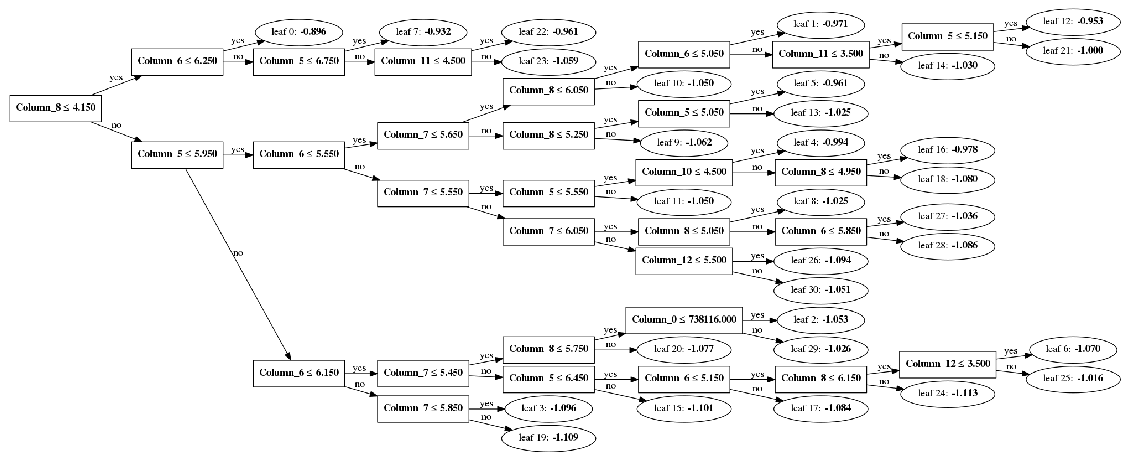

In [119]:
from lightgbm import plot_tree

plot_tree(clf, figsize=(20,20))
plt.show()

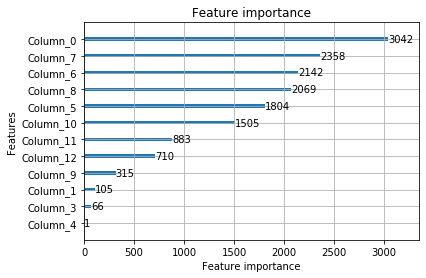

In [120]:
from lightgbm import plot_importance
plot_importance(clf)

### XGBoost

In [149]:
# Criação de uma Transform personalizada ``DropColumns``

rm_columns = DropColumns(
    columns=["NOME"]
)

# Criação de um objeto ``SimpleImputer``

si = SimpleImputer(
    missing_values=np.nan,  # os valores faltantes são do tipo ``np.nan`` (padrão Pandas)
    strategy='constant',  # a estratégia escolhida é a alteração do valor faltante por uma constante
    fill_value=0,  # a constante que será usada para preenchimento dos valores faltantes é um int64=0.
#     strategy = "most_frequent",
    verbose=0,
    copy=True
)


# clf =  lgbm.LGBMClassifier()
clf_xgb = XGBClassifier(verbose=1)

pipeline = Pipeline(
    steps=[
        ('remove_cols', rm_columns),
        ('add_features', AddFeatures()),
        ('imputer', si),
        ('clf', clf_xgb),
    ]
)

# Inicialização da Pipeline (pré-processamento e realização do treinamento do modelo)
pipeline.fit(X_train, y_train.values.ravel())

# Realização de teste cego no modelo criado

# Acurácia alcançada pela árvore de decisão
y_pred = pipeline.predict(X_test)
print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 4)))


print(classification_report(y_test, y_pred))

[08:32:15] WARNING: /workspace/src/learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Acurácia: 80.47%
              precision    recall  f1-score   support

 DIFICULDADE       0.87      0.75      0.81      1681
      EXATAS       0.82      0.91      0.86      2035
   EXCELENTE       0.60      0.53      0.56       158
     HUMANAS       0.74      0.93      0.82       753
   MUITO_BOM       0.40      0.13      0.19       243

   micro avg       0.80      0.80      0.80      4870
   macro avg       0.68      0.65      0.65      4870
weighted avg       0.80      0.80      0.79      4870



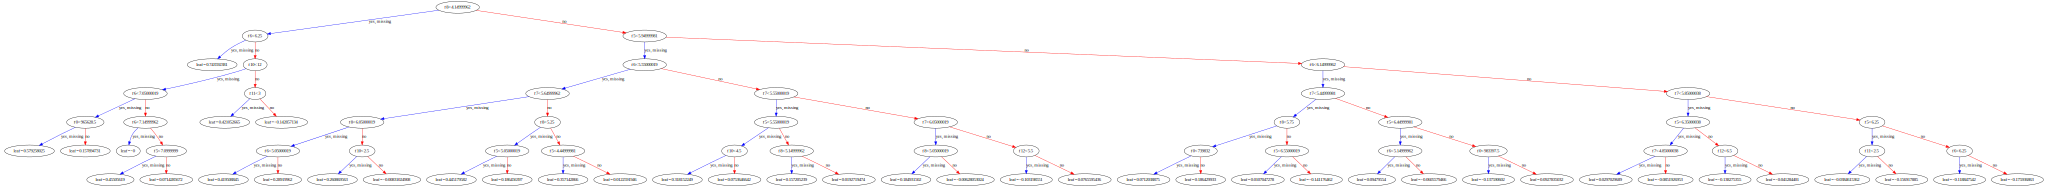

In [122]:
from xgboost import plot_tree, to_graphviz
import matplotlib.pyplot as plt

# plot_tree(best_clf, figsize=(10,10))
to_graphviz(clf_xgb)

# plt.show()

## Tunando LGBM com Bayesian Optimization

In [150]:
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.utils import use_named_args
from skopt.space import Real, Integer

si = SimpleImputer(
    missing_values=np.nan,  # os valores faltantes são do tipo ``np.nan`` (padrão Pandas)
    strategy='constant',  # a estratégia escolhida é a alteração do valor faltante por uma constante
    fill_value=0,  # a constante que será usada para preenchimento dos valores faltantes é um int64=0.
#     strategy = "most_frequent",
    verbose=0,
#     add_indicator=True,
    copy=True
)

# The list of hyper-parameters we want to optimize
space = [
    Integer(2, 256, name="num_leaves"),
    Real(10 ** -3, 0.8, "log-uniform", name="learning_rate"),
    Integer(1, 512, name="min_child_samples"),
    Real(0.01, 1.00, name="subsample"),
    Real(0.1, 1.00, name="colsample_bytree"),
]

params_names = [dim.name for dim in space]

@use_named_args(space)
def objective(**params):
    clf.set_params(**params)
    pipeline = Pipeline(
        steps=[
#             ('remove_cols', rm_columns),
            ('add_features', AddFeatures()),
            ('imputer', si),
            ('clf', clf),
        ]
    )
        
    _X_train =  X_train.drop(columns=["NOME"], axis='columns')
    
    return -np.mean(cross_val_score(pipeline, _X_train, y_train, cv=3, n_jobs=1,
                            scoring="accuracy"))

# do bayesian optimization

clf = lgbm.LGBMClassifier(random_state=42)
# clf = XGBClassifier()

result_gp = gp_minimize(
    objective, space, random_state=42, verbose=1, n_calls=10, n_random_starts=5
)

# get best params and make the best classifier
best_params = dict(zip(params_names, result_gp.x))

# best_clf = XGBClassifier(**best_params)
best_clf = lgbm.LGBMClassifier(**best_params)

Iteration No: 1 started. Evaluating function at random point.


/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/s

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.2766
Function value obtained: -0.6230
Current minimum: -0.6230
Iteration No: 2 started. Evaluating function at random point.


/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/s

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.9707
Function value obtained: -0.8118
Current minimum: -0.8118
Iteration No: 3 started. Evaluating function at random point.


/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/s

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.4089
Function value obtained: -0.8086
Current minimum: -0.8118
Iteration No: 4 started. Evaluating function at random point.


/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/s

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 8.2813
Function value obtained: -0.8051
Current minimum: -0.8118
Iteration No: 5 started. Evaluating function at random point.


/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/s

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.3576
Function value obtained: -0.6196
Current minimum: -0.8118
Iteration No: 6 started. Searching for the next optimal point.


/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/s

Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 0.8835
Function value obtained: -0.8058
Current minimum: -0.8118
Iteration No: 7 started. Searching for the next optimal point.


/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/s

Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 1.0155
Function value obtained: -0.7940
Current minimum: -0.8118
Iteration No: 8 started. Searching for the next optimal point.


/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/s

Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 1.7225
Function value obtained: -0.8124
Current minimum: -0.8124
Iteration No: 9 started. Searching for the next optimal point.


/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/s

Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 1.0786
Function value obtained: -0.8095
Current minimum: -0.8124
Iteration No: 10 started. Searching for the next optimal point.


/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/s

Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 0.9365
Function value obtained: -0.7080
Current minimum: -0.8124


In [151]:
best_params

{'num_leaves': 16,
 'learning_rate': 0.04255941370614545,
 'min_child_samples': 55,
 'subsample': 0.048101030476692466,
 'colsample_bytree': 0.6439559798028359}

In [152]:
best_pipeline = Pipeline(
    steps=[
        ('remove_cols', rm_columns),
        ('imputer', si),
        ('clf', best_clf),
    ]
)
best_pipeline.fit(X_train, y_train.values.ravel())

y_pred = best_pipeline.predict(X_test)
print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 4)))

Acurácia: 81.27%


In [153]:
%matplotlib inline

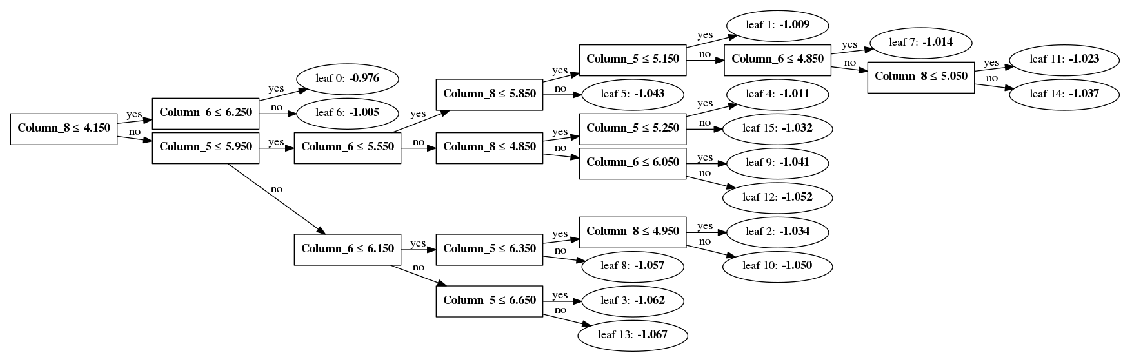

In [155]:
from lightgbm import plot_tree, plot_importance

plot_tree(best_clf, figsize=(20,20))
plt.show()

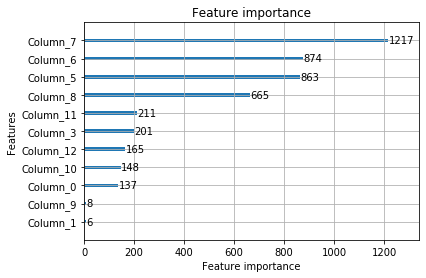

In [60]:
plot_importance(best_clf)

### XGBoost com tunning

In [156]:
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.utils import use_named_args
from skopt.space import Real, Integer

# The list of hyper-parameters we want to optimize
space = [
    Integer(2, 256, name="num_leaves"),
    Real(10 ** -3, 0.5, "log-uniform", name="learning_rate"),
    Integer(3, 50, name="max_depth"),
    Integer(1, 256, name="min_child_samples"),
    Real(0.05, 1.00, name="subsample"),
    Real(0.1, 1.00, name="colsample_bytree"),
    Integer(1, 10, name="min_child_weight")
#     Integer(10,500, name="n_estimators")
]


params_names = [dim.name for dim in space]

@use_named_args(space)
def objective(**params):
    clf.set_params(**params)
    pipeline = Pipeline(
        steps=[
#             ('remove_cols', rm_columns),
            ('add_features', AddFeatures()),
            ('imputer', si),
            ('clf', clf),
        ]
    )
    
    _X_train =  X_train.drop(columns=["NOME"], axis='columns')
    return -np.mean(cross_val_score(pipeline, _X_train, y_train, cv=3, n_jobs=1,
                            scoring="accuracy"))

# do bayesian optimization

clf = XGBClassifier()

result_gp = gp_minimize(
    objective, space, random_state=42, verbose=1, n_calls=20, n_random_starts=5
)

# get best params and make the best classifier
best_params = dict(zip(params_names, result_gp.x))

best_clf = XGBClassifier(**best_params)

Iteration No: 1 started. Evaluating function at random point.
[08:34:04] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:34:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:34:06] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.1980
Function value obtained: -0.7063
Current minimum: -0.7063
Iteration No: 2 started. Evaluating function at random point.
[08:34:08] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:34:12] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:34:16] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 12.4329
Function value obtained: -0.8105
Current minimum: -0.8105
Iteration No: 3 started. Evaluating function at random point.
[08:34:20] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:34:22] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:34:22] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.1041
Function value obtained: -0.8120
Current minimum: -0.8120
Iteration No: 4 started. Evaluating function at random point.
[08:34:23] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:34:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:34:30] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.9913
Function value obtained: -0.7879
Current minimum: -0.8120
Iteration No: 5 started. Evaluating function at random point.
[08:34:31] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:34:32] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:34:33] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3.1623
Function value obtained: -0.7974
Current minimum: -0.8120
Iteration No: 6 started. Searching for the next optimal point.
[08:34:35] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:34:39] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:34:43] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 15.2168
Function value obtained: -0.7881
Current minimum: -0.8120
Iteration No: 7 started. Searching for the next optimal point.
[08:34:50] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:34:51] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:34:52] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 4.3231
Function value obtained: -0.8044
Current minimum: -0.8120
Iteration No: 8 started. Searching for the next optimal point.
[08:34:54] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:34:58] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:01] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 10.6164
Function value obtained: -0.7833
Current minimum: -0.8120
Iteration No: 9 started. Searching for the next optimal point.
[08:35:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:09] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:13] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 13.2266
Function value obtained: -0.7895
Current minimum: -0.8120
Iteration No: 10 started. Searching for the next optimal point.
[08:35:18] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:19] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:21] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 4.4590
Function value obtained: -0.8086
Current minimum: -0.8120
Iteration No: 11 started. Searching for the next optimal point.
[08:35:22] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:24] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:25] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 4.5104
Function value obtained: -0.8089
Current minimum: -0.8120
Iteration No: 12 started. Searching for the next optimal point.
[08:35:27] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:28] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:29] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 3.6742
Function value obtained: -0.8020
Current minimum: -0.8120
Iteration No: 13 started. Searching for the next optimal point.
[08:35:31] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:33] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:36] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 7.9047
Function value obtained: -0.8125
Current minimum: -0.8125
Iteration No: 14 started. Searching for the next optimal point.
[08:35:38] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:41] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:44] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 8.4617
Function value obtained: -0.8100
Current minimum: -0.8125
Iteration No: 15 started. Searching for the next optimal point.
[08:35:47] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:48] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:50] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 5.5669
Function value obtained: -0.8070
Current minimum: -0.8125
Iteration No: 16 started. Searching for the next optimal point.
[08:35:53] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:54] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:55] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 4.1107
Function value obtained: -0.8087
Current minimum: -0.8125
Iteration No: 17 started. Searching for the next optimal point.
[08:35:57] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:35:59] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:36:02] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 8.2645
Function value obtained: -0.8118
Current minimum: -0.8125
Iteration No: 18 started. Searching for the next optimal point.
[08:36:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:36:07] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:36:12] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 12.8655
Function value obtained: -0.8110
Current minimum: -0.8125
Iteration No: 19 started. Searching for the next optimal point.
[08:36:18] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:36:31] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:36:45] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 43.5553
Function value obtained: -0.8077
Current minimum: -0.8125
Iteration No: 20 started. Searching for the next optimal point.
[08:37:01] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:37:06] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/luan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:37:11] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 16.9808
Function value obtained: -0.8085
Current minimum: -0.8125


In [157]:
best_params

{'num_leaves': 256,
 'learning_rate': 0.001,
 'max_depth': 26,
 'min_child_samples': 1,
 'subsample': 1.0,
 'colsample_bytree': 0.5696042729007419,
 'min_child_weight': 10}

In [158]:
best_pipeline = Pipeline(
    steps=[
        ('remove_cols', rm_columns),
        ('imputer', si),
        ('clf', best_clf),
    ]
)
best_pipeline.fit(X_train, y_train.values.ravel())

y_pred = best_pipeline.predict(X_test)
print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 4)))

[08:37:18] WARNING: /workspace/src/learner.cc:480: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Acurácia: 80.51%


In [74]:
best_pipeline.predict(X_test.head())

array(['EXATAS', 'DIFICULDADE', 'DIFICULDADE', 'EXATAS', 'EXATAS'],
      dtype=object)

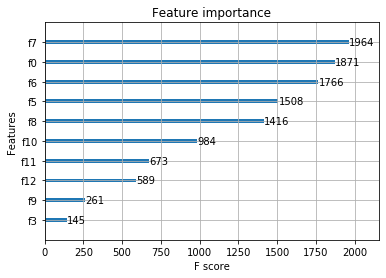

In [75]:
from xgboost import plot_importance
plot_importance(best_clf, max_num_features=10)

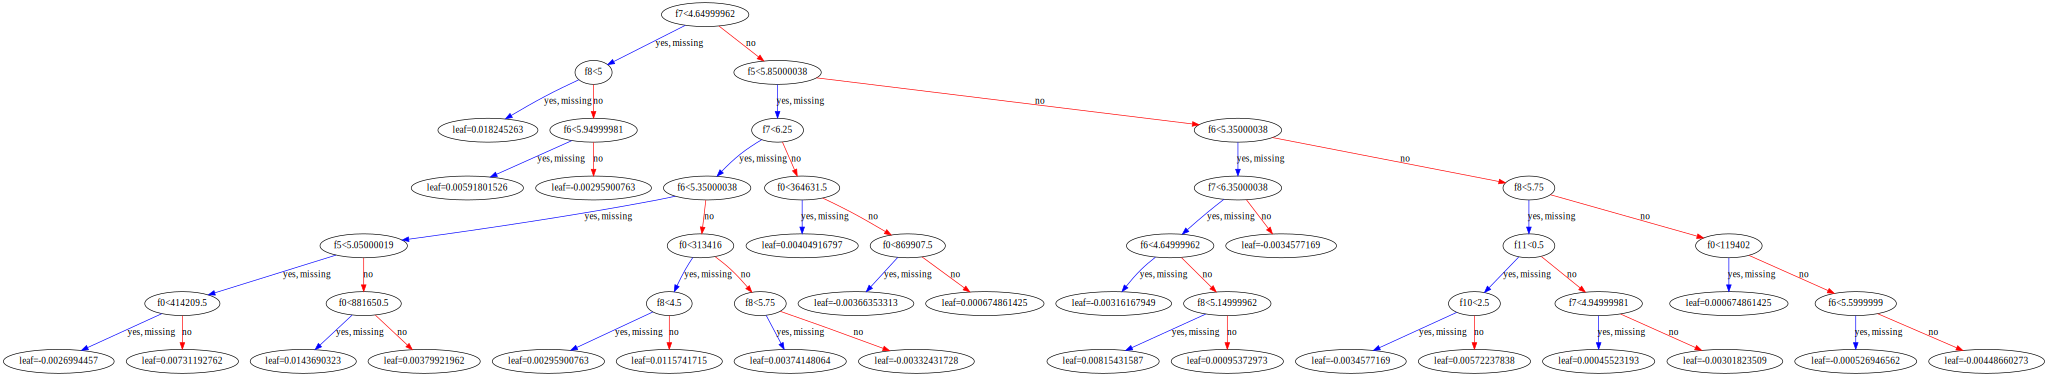

In [53]:
from xgboost import plot_tree, to_graphviz
import matplotlib.pyplot as plt

# plot_tree(best_clf, figsize=(10,10))
to_graphviz(best_clf)

# plt.show()

### Encapsulando uma Pipeline personalizada no Watson Machine Learning

#### Estabelecendo conexão entre o cliente Python do WML e a sua instância do serviço na nuvem

In [ ]:
# Biblioteca Python com implementação de um cliente HTTP para a API do WML
from watson_machine_learning_client import WatsonMachineLearningAPIClient

As próximas células irão realizar o deploy da pipeline declarada neste notebook no WML. Só prossiga se você já está satisfeito com seu modelo e acha que já é a hora de fazer o deploy da sua solução.

Cole as credenciais de sua instância do Watson Machine Learning na variável na célula abaixo.

É importante que a variável que contém os valores tenha o nome de ``wml_credentials`` para que as próximas células deste notebook executem corretamente.

In [ ]:
wml_credentials = {
  "apikey": "",
  "iam_apikey_description": "",
  "iam_apikey_name": "",
  "iam_role_crn": "",
  "iam_serviceid_crn": "",
  "instance_id": "",
  "url": ""
}

In [ ]:
# Instanciando um objeto cliente do Watson Machine Learning a partir das credenciais fornecidas

clientWML = WatsonMachineLearningAPIClient(wml_credentials)

In [ ]:
# Extraindo detalhes da sua instância do Watson Machine Learning

instance_details = clientWML.service_instance.get_details()
print(json.dumps(instance_details, indent=4))

**ATENÇÃO!!**

Fique atento para os limites de consumo de sua instância do Watson Machine Learning!

Caso você expire a camada grátis, não será possível avaliar seu modelo (pois é necessária a realização de algumas chamadas de API que consomem predições!)

#### Listando todos os artefatos armazenados no seu WML

Para listar todos os artefatos armazenados em seu Watson Machine Learning, você pode usar a seguinte função:

    clientWML.repository.list()

In [ ]:
# Listando todos os artefatos atualmente armazenados na sua instância do WML

clientWML.repository.list()

No plano LITE do Watson Machine Learning só é permitido o deploy de um único modelo por vez. Se for o caso de você já possuir um modelo online na sua instância, você pode apagá-lo utilizando o método clientWML.repository.delete():

    artifact_guid = "359c8951-d2fe-4063-8706-cc06b32d5e0d"
    clientWML.repository.delete(artifact_guid)

#### Criando uma nova definição de pacote Python personalizado no WML

O primeiro passo para realizar seu deploy é armazenar o código das transformações personalizadas criadas por você.

Para essa etapa precisamos apenas do arquivo .zip do pacote criado (que já possuimos carregado no Kernel!)

In [ ]:
# Definição de metadados do nosso pacote com as Transforms personalizadas
pkg_meta = {
    clientWML.runtimes.LibraryMetaNames.NAME: "my_custom_sklearn_transform_1",
    clientWML.runtimes.LibraryMetaNames.DESCRIPTION: "A custom sklearn transform",
    clientWML.runtimes.LibraryMetaNames.FILEPATH: "sklearn_transforms.zip",  # Note que estamos utilizando o .zip criado anteriormente!
    clientWML.runtimes.LibraryMetaNames.VERSION: "1.0",
    clientWML.runtimes.LibraryMetaNames.PLATFORM: { "name": "python", "versions": ["3.6"] }
}
custom_package_details = clientWML.runtimes.store_library( pkg_meta )
custom_package_uid = clientWML.runtimes.get_library_uid( custom_package_details )

print("\n Lista de artefatos de runtime armazenados no WML:")
clientWML.repository.list()

#### Criando uma nova definição de runtime Python personalizado no WML

O segundo passo é armazenar uma definição de runtime Python para utilizar a nossa biblioteca personalizada.

Isso pode ser feito da seguinte forma:

In [ ]:
runtime_meta = {
    clientWML.runtimes.ConfigurationMetaNames.NAME: "my_custom_wml_runtime_1",
    clientWML.runtimes.ConfigurationMetaNames.DESCRIPTION: "A Python runtime with custom sklearn Transforms",
    clientWML.runtimes.ConfigurationMetaNames.PLATFORM: {
        "name": "python",
        "version": "3.6"
    },
    clientWML.runtimes.ConfigurationMetaNames.LIBRARIES_UIDS: [ custom_package_uid ]
}
runtime_details = clientWML.runtimes.store( runtime_meta )
custom_runtime_uid = clientWML.runtimes.get_uid( runtime_details )

print("\n Detalhes do runtime armazenado:")
print(json.dumps(runtime_details, indent=4))

In [ ]:
# Listando todos runtimes armazenados no seu WML:
clientWML.runtimes.list()

#### Criando uma nova definição de Pipeline personalizada no WML

Finalmente iremos criar uma definição (metadados) para a nossa Pipeline ser hospedada no WML.

Definimos como parâmetros um nome para o artefato e o ID do runtime criado anteriormente.

In [ ]:
model_meta = {
    clientWML.repository.ModelMetaNames.NAME: 'desafio-2-mbtc2020-pipeline-1',
    clientWML.repository.ModelMetaNames.DESCRIPTION: "my pipeline for submission",
    clientWML.repository.ModelMetaNames.RUNTIME_UID: custom_runtime_uid
}

Em seguida chamamos o método para armazenar a nova definição:

In [ ]:
# Função para armazenar uma definição de Pipeline no WML
stored_model_details = clientWML.repository.store_model(
    model=my_pipeline,  # `my_pipeline` é a variável criada anteriormente e contém nossa Pipeline já treinada :)
    meta_props=model_meta,  # Metadados definidos na célula anterior
    training_data=None  # Não altere esse parâmetro
)

print("\n Lista de artefatos armazenados no WML:")
clientWML.repository.list()

# Detalhes do modelo hospedado no Watson Machine Learning
print("\n Metadados do modelo armazenado:")
print(json.dumps(stored_model_details, indent=4))

#### Realizando o deployment do seu modelo para consumo imediato por outras aplicações

In [ ]:
# O deployment do modelo é finalmente realizado por meio do método ``deployments.create()``

model_deployment_details = clientWML.deployments.create(
    artifact_uid=stored_model_details["metadata"]["guid"],  # Não altere esse parâmetro
    name="desafio-2-mbtc2020-deployment-1",
    description="Solução do desafio 2 - MBTC",
    asynchronous=False,  # Não altere esse parâmetro
    deployment_type='online',  # Não altere esse parâmetro
    deployment_format='Core ML',  # Não altere esse parâmetro
    meta_props=model_meta  # Não altere esse parâmetro
)

#### Testando um modelo hospedado no Watson Machine Learning

In [ ]:
# Recuperando a URL endpoint do modelo hospedado na célula anterior

model_endpoint_url = clientWML.deployments.get_scoring_url(model_deployment_details)
print("A URL de chamada da sua API é: {}".format(model_endpoint_url))

In [ ]:
# Detalhes do deployment realizado

deployment_details = clientWML.deployments.get_details(
    deployment_uid=model_deployment_details["metadata"]["guid"]  # esse é o ID do seu deployment!
)

print("Metadados do deployment realizado: \n")
print(json.dumps(deployment_details, indent=4))

In [ ]:
scoring_payload = {
    'fields': [
        "MATRICULA", "NOME", 'REPROVACOES_DE', 'REPROVACOES_EM', "REPROVACOES_MF", "REPROVACOES_GO",
        "NOTA_DE", "NOTA_EM", "NOTA_MF", "NOTA_GO",
        "INGLES", "H_AULA_PRES", "TAREFAS_ONLINE", "FALTAS", 
    ],
    'values': [
        [
            513949,"Marli Quésia de Oliveira",1,1,1,1,4.3,4.0,3.1,4.9,0,3,4,3,
        ]
    ]
}

print("\n Payload de dados a ser classificada:")
print(json.dumps(scoring_payload, indent=4))

In [ ]:
result = clientWML.deployments.score(
    model_endpoint_url,
    scoring_payload
)

print("\n Resultados:")
print(json.dumps(result, indent=4))

<hr>

## Parabéns! 

Se tudo foi executado sem erros, você já tem um classificador baseado em machine learning encapsulado como uma API REST!

Para testar a sua solução integrada com um assistente virtual e realizar a submissão, acesse a página:

https://uninassau.maratona.dev

Você irá precisar da endpoint url do seu modelo e das credenciais do WML :)